In [1]:
import gymnasium as gym
import numpy as np
import random

In [2]:
env = gym.make('CartPole-v1')
states = env.observation_space.shape
actions= env.action_space.n
print(f"state shape: {states} \nactions shape:{actions}")

state shape: (4,) 
actions shape:2


# Making a simple policy:

In [3]:
def policy(state):
    angle = state[2]
    return 0 if angle < 0 else 1 

episodes = 10
for i in range(episodes):
    state, _ = env.reset()
    score = 0 
    done = False
    while not done :
        action = policy(state)
        state, reward, done, truncated, info = env.step(action)
        score += reward 
        
        if done or truncated :
            break
    
    print(f"Episode: {i+1} , Score: {score}")

# env.close()

Episode: 1 , Score: 25.0
Episode: 2 , Score: 35.0
Episode: 3 , Score: 39.0
Episode: 4 , Score: 45.0
Episode: 5 , Score: 45.0
Episode: 6 , Score: 25.0
Episode: 7 , Score: 47.0
Episode: 8 , Score: 35.0
Episode: 9 , Score: 45.0
Episode: 10 , Score: 44.0


In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential

model = Sequential([
    Input(states),
    Dense(units=25, activation='relu'),
    Dense(units=25, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [5]:
def play_one_step(env, state, model, loss_fn):
    with tf.GradientTape() as tape:
        left_prob = model(state[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_prob)
        y_target = tf.constant([[1.0]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_prob))
    grads = tape.gradient(loss, model.trainable_variables)
    state, reward, done, trauncated, info = env.step(int(action[0,0].numpy()))
    return state, reward, done, trauncated, info, grads

In [6]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = [] 
    all_grads = [] 
    for episode in range(n_episodes):
        current_rewards = [] 
        current_grads = [] 
        state, _ = env.reset()
        for step in range(n_max_steps):
            state, reward, done, truncated, info, grads = play_one_step(env, state, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
        return all_rewards, all_grads
        
        

In [7]:
def discount_rewards(rewards, discount_factor):
    discounted_rewards = np.array(rewards)
    for step in range(len(rewards) - 2 , -1 , -1):
        discounted_rewards[step] += discounted_rewards[step + 1] * discount_factor

    return discounted_rewards

In [8]:
def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                                 for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [9]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

In [10]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [22]:
n_iterations = 150 
n_episodes_per_iteration = 15
n_max_steps = 500 
discount_factor = 0.95 
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
loss_fn = tf.losses.binary_crossentropy

In [23]:
env = gym.make('CartPole-v1')

average_rewards = []
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_iteration, n_max_steps, model, loss_fn)
    final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)

    final_grads = [] 

     # Total reward per episode
    episode_returns = [sum(rewards) for rewards in all_rewards]
    
    # Print the average return across all episodes in this iteration
    average_reward = np.mean(episode_returns)
    average_rewards.append(average_reward)
    print(f"Iteration {iteration + 1}: Average Reward = {average_reward:.2f}")
    for variable_idx in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean([final_reward * all_grads[episode][step][variable_idx]
                                   for episode, rewards in enumerate(final_rewards)
                                    for step, final_reward in enumerate(rewards)] , axis=0)
        final_grads.append(mean_grads)
    optimizer.apply_gradients(zip(final_grads , model.trainable_variables))
    
        

Iteration 1: Average Reward = 9.00
Iteration 2: Average Reward = 31.00
Iteration 3: Average Reward = 30.00
Iteration 4: Average Reward = 15.00
Iteration 5: Average Reward = 13.00
Iteration 6: Average Reward = 21.00
Iteration 7: Average Reward = 24.00
Iteration 8: Average Reward = 14.00
Iteration 9: Average Reward = 51.00
Iteration 10: Average Reward = 21.00
Iteration 11: Average Reward = 28.00
Iteration 12: Average Reward = 26.00
Iteration 13: Average Reward = 32.00
Iteration 14: Average Reward = 36.00
Iteration 15: Average Reward = 17.00
Iteration 16: Average Reward = 19.00
Iteration 17: Average Reward = 38.00
Iteration 18: Average Reward = 16.00
Iteration 19: Average Reward = 37.00
Iteration 20: Average Reward = 70.00
Iteration 21: Average Reward = 31.00
Iteration 22: Average Reward = 28.00
Iteration 23: Average Reward = 34.00
Iteration 24: Average Reward = 42.00
Iteration 25: Average Reward = 33.00
Iteration 26: Average Reward = 32.00
Iteration 27: Average Reward = 32.00
Iteration 2

In [13]:


def get_action(model, state):
    left_prob = model(state[np.newaxis])
    return 0 if left_prob > 0.5 else 1 
def gradient_policy(model, env):
    state,_ = env.reset()
    done = False 
    score = 0 
    while not done:
        action = get_action(model, state)
        state, reward, done, truncated, info = env.step(action)
        score += reward
        if done or truncated:
            break
    print(f"Final Score: {score}")

In [29]:
env = gym.make('CartPole-v1' , render_mode='human')

gradient_policy(model, env)

env.close()

Final Score: 500.0


In [27]:
model.save("cartpole_model.keras")


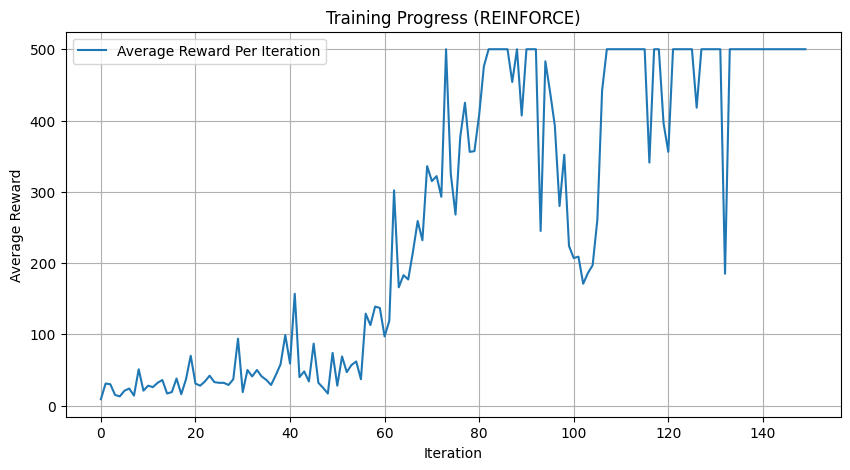

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(average_rewards, label="Average Reward Per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Average Reward")
plt.title("Training Progress (REINFORCE)")
plt.grid(True)
plt.legend()
plt.show()


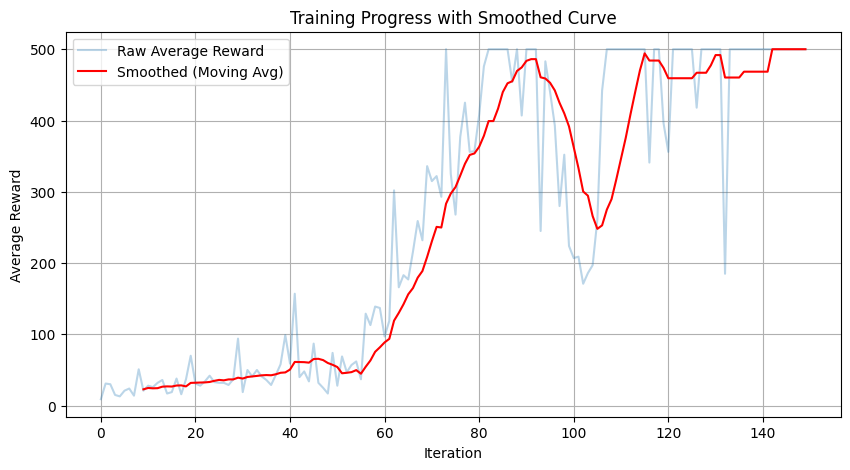

In [28]:
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed = moving_average(average_rewards, window_size=10)

plt.figure(figsize=(10, 5))
plt.plot(average_rewards, alpha=0.3, label='Raw Average Reward')
plt.plot(range(10 - 1, len(average_rewards)), smoothed, color='red', label='Smoothed (Moving Avg)')
plt.xlabel("Iteration")
plt.ylabel("Average Reward")
plt.title("Training Progress with Smoothed Curve")
plt.grid(True)
plt.legend()
plt.show()


In [30]:
# Testing the model on some weird states:

env = gym.make("CartPole-v1", render_mode = 'human')

state, _ = env.reset()
#initial state: [cart_position, cart_velocity, pole_angle, pole_angular_velocity]
custom_state = np.array([0.5, 0.0, 0.2, 0.0])  # cart is to the right, pole is tilted
env.unwrapped.state = custom_state.copy()
obs = custom_state  # update current obs manually

gradient_policy(model, env)
env.close()

Final Score: 500.0


In [ ]:
test_states = [
    ("🚀 Pole tilted right",     [0.0, 0.0, 0.2, 0.0]),
    ("🚀 Pole tilted left",      [0.0, 0.0, -0.2, 0.0]),
    ("💨 Cart moving right",     [0.0, 2.0, 0.0, 0.0]),
    ("💨 Cart moving left",      [0.0, -2.0, 0.0, 0.0]),
    ("🔀 Pole swinging right",   [0.0, 0.0, 0.0, 1.0]),
    ("🔀 Pole swinging left",    [0.0, 0.0, 0.0, -1.0]),
    ("🎯 Far right + tilted left",[1.5, 0.0, -0.2, 0.0]),
    ("🎯 Far left + tilted right",[-1.5, 0.0, 0.2, 0.0]),
    ("💥 Wild state 1",          [1.0, 1.5, 0.15, -1.5]),
    ("💥 Wild state 2",          [-1.0, -1.5, -0.15, 1.5]),
    ("✅ Normal start",          [0.0, 0.0, 0.0, 0.0]),
]

def test_custom_states(model, env, test_cases):
    for description, state in test_cases:
        env.reset()
        env.unwrapped.state = np.array(state)
        obs = np.array(state)
        done = False
        score = 0

        while not done:
            action = get_action(model, obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            score += reward
        
        print(f"{description} → Final Score: {score}")


In [ ]:
env = gym.make("CartPole-v1", render_mode = 'human')

test_custom_states(model, env, test_states)
env.close()